In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import json
import math
import scipy

# EDA + Data Pre-Process

In [7]:
def plot_waveform(audio, sample_rate):
    # Plots the waveform of audio in the time domain.
    plt.figure(figsize=(12, 6))
    librosa.display.waveshow(audio, sr = sample_rate, alpha=0.8)
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def calc_spec_db(audio, kind='mag'):
    """
    Compute the spectrum of an audio signal and represent it in decibels.
    Depending on the `kind`, this can calculate:
    - 'mag': Magnitude spectrum (energy levels of frequencies)
    - 'phs': Phase spectrum (phase information)
    - 'com': Complex spectrum (both magnitude and phase)
    Returns the spectrum in decibel scale.
    """
    # Compute the Fast Fourier Transform (FFT) of the audio signal
    spec = scipy.fft.fft(x=audio)
    if kind.lower() in ['mag', 'magnitude']:
        spec_db = 20 * np.log10(np.abs(spec))
    elif kind.lower() in ['phs', 'phase']:
        spec_db = 20 * np.log10(np.imag(spec))
    elif kind.lower() in ['com', 'complex']:
        spec_db = 20 * np.log10(spec)
    else:
        raise ValueError("Invalid kind. Use 'mag', 'phs', or 'com'.")

    return spec_db

In [8]:
def plot_spec(audio, fs, kind='mag'):
    """
    Visualize the spectrum of an audio signal (energy vs frequency).
    Helps find out which frequencies are dominant in the audio.
    """
    spec_db = calc_spec_db(audio, kind=kind)  # Get the spectrum in decibels
    f_axis = np.linspace(0, fs, len(spec_db))  # Frequency axis

    # Focus only on frequencies below the Nyquist limit (half the sampling rate)
    f_axis = f_axis[:len(spec_db) // 2]
    spec_db = spec_db[:len(spec_db) // 2]

    # Plot the spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(f_axis, spec_db, alpha=0.8)
    plt.xscale('log')  # Use a logarithmic scale for better visibility
    plt.xlim(1, fs / 2)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Audio Spectrum")
    plt.grid()
    plt.show()

In [9]:
def calc_stft(audio, fs, n_fft=2048, hop_length=512, dB=True):
    """
    Compute the Short-Time Fourier Transform (STFT) of the audio, which helps
    analyze how frequency content changes over time.
    """
    stft = np.abs(librosa.stft(y=audio, n_fft=n_fft, hop_length=hop_length))
    # Convert to decibels if specified
    if dB:
        stft = librosa.amplitude_to_db(stft, ref=np.max)

    return stft


def plot_spectrogram(audio, fs, n_fft=2048, hop_length=512, dB=True):
    """
    Display the spectrogram of the audio, combines time, frequency, and energy info.
    """
    stft_db = calc_stft(audio, fs, n_fft=n_fft, hop_length=hop_length, dB=dB)
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(stft_db, sr=fs, x_axis="time", y_axis="log", cmap="viridis")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()

In [38]:
def calc_mel_spec(audio, fs, n_mfccs=128, n_fft=2048, hop_length=512):
    """
    Compute the Mel-scaled spectrogram, which represents sound as humans hear it.
    """
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=fs, n_mels=n_mfccs, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def plot_mel_spectrogram_audio(audio, fs, n_mfccs=128, n_fft=2048, hop_length=512):
    """
    Display the Mel-scaled spectrogram, a compressed version of the spectrogram.
    """
    mel_spec_db = calc_mel_spec(audio, fs, n_mfccs=n_mfccs, n_fft=n_fft, hop_length=hop_length)
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(mel_spec_db, sr=fs, x_axis="time", y_axis="mel", cmap="viridis")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Power Spectrogram")
    plt.tight_layout()
    plt.show()

def plot_mfcc(mfcc, fs, title: str = "MFCCs"):
    """
    Display the Mel Frequency Cepstral Coefficients (MFCCs) of the audio.
    """
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(mfcc, sr=fs, x_axis="time", y_axis="mel", cmap="viridis")
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

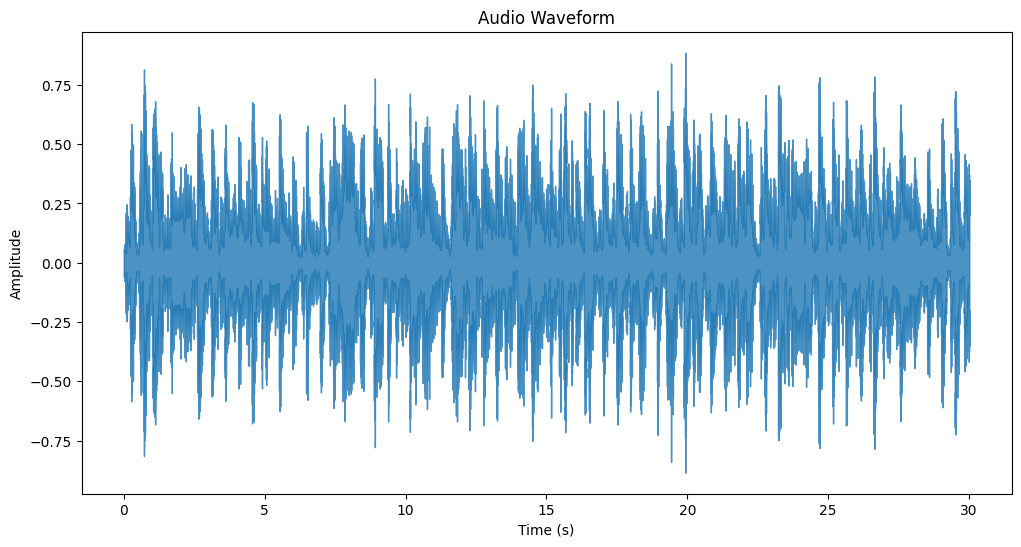

In [21]:
path = './data/genres_original/'
genre = 'blues/'
file = 'blues.00000.wav'
path = path + genre + file

# Load the audio file
fs = 22050
audio, fs = librosa.load(path, sr=fs)

# Plot the waveform
plot_waveform(audio, fs)

In [22]:
print(f"Audio Length: {len(audio)} samples")
print(f"Sampling Rate: {fs} Hz")

Audio Length: 661794 samples
Sampling Rate: 22050 Hz


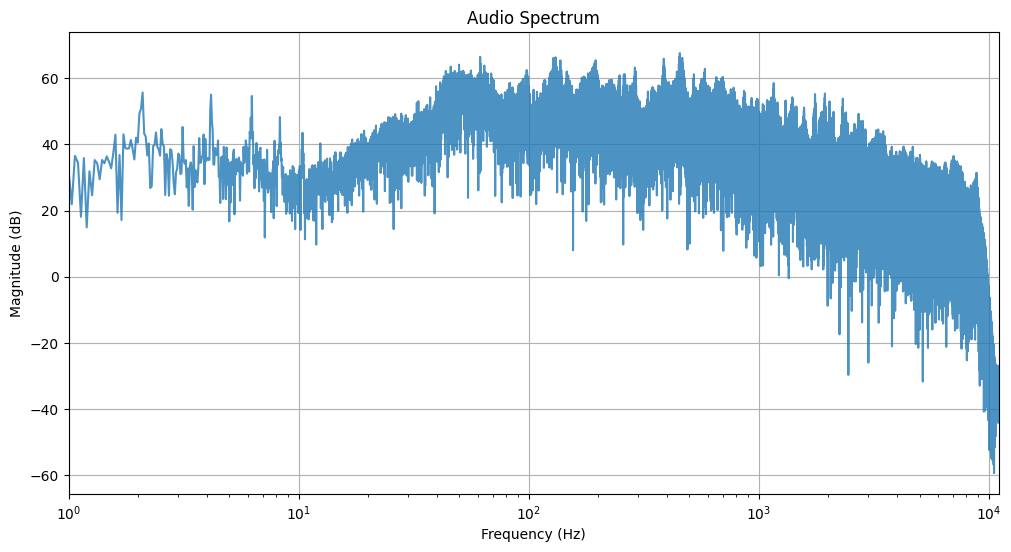

In [23]:
plot_spec(audio, fs, kind='mag')

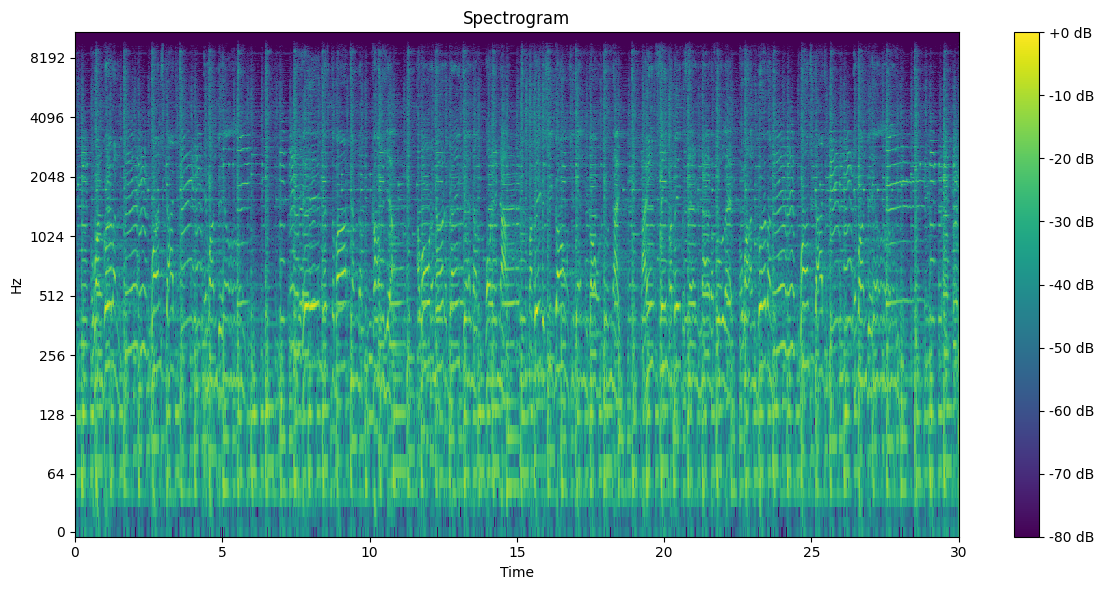

In [24]:
n_fft = 2048
hop_length = 512
dB = True
plot_spectrogram(audio, fs, n_fft=n_fft, hop_length=hop_length, dB=dB)

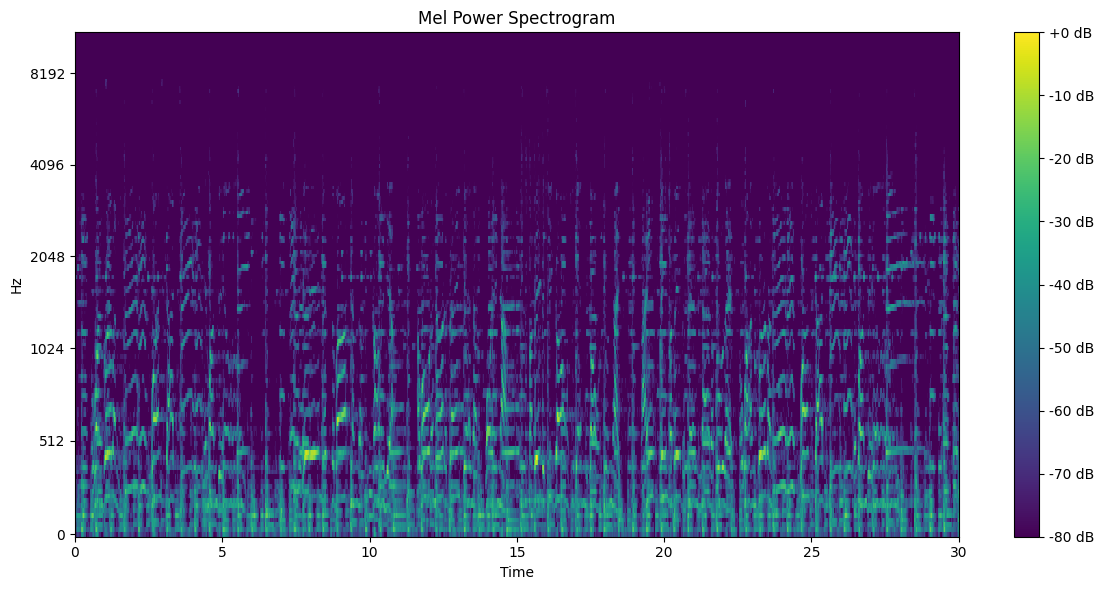

In [25]:
n_mfccs = 128
plot_mel_spectrogram_audio(audio, fs, n_mfccs=n_mfccs, n_fft=n_fft, hop_length=hop_length)

In [29]:
def get_mfccs(directory_path, fs=22050, duration=30, n_fft=2048, hop_length=512, n_mfcc=13, num_segments=10):
    """
    Extract MFCCs from all audio files in the specified directory.
    Splits audio into smaller segments for better training data.
        - Each segment is processed separately to increase data samples.
        - MFCCs are stored with their associated genre names and IDs.
    Saves the processed data to a JSON file for faster reuse.
    """
    data = {"genre_name": [], "genre_num": [], "mfcc": []}
    samples_per_track = fs * duration
    samples_per_segment = int(samples_per_track / num_segments)
    mfccs_per_segment = math.ceil(samples_per_segment / hop_length)

    print("Starting MFCC extraction...")
    for idx, (path, _, files) in enumerate(os.walk(directory_path)):
        if path != directory_path:
            genre = os.path.basename(path)
            for file in files:
                try:
                    file_path = os.path.join(path, file)
                    audio, _ = librosa.load(file_path, sr=fs)
                    for segment in range(num_segments):
                        start = segment * samples_per_segment
                        end = start + samples_per_segment
                        mfcc = librosa.feature.mfcc(y=audio[start:end], sr=fs, n_mfcc=n_mfcc,
                                                    n_fft=n_fft, hop_length=hop_length).T
                        if len(mfcc) == mfccs_per_segment:
                            data["genre_name"].append(genre)
                            data["genre_num"].append(idx - 1)
                            data["mfcc"].append(mfcc.tolist())
                except Exception as e:
                    print(f"Skipping file {file}: {e}")
            print(f"Finished collecting MFCCs for the '{genre.title()}' genre!")

    with open("data.json", "w") as f:
        json.dump(data, f, indent=4)
    print("MFCC extraction complete. Data saved to 'data.json'.")
    return np.array(data["mfcc"]), np.array(data["genre_name"]), np.array(data["genre_num"])


In [32]:
n_mfcc = 13
num_segments = 10
n_fft = 2048
hop_length = 512
duration = 30
path = "./data/genres_original/"

mfccs, genres, genre_nums = get_mfccs(directory_path=path, fs=fs, duration=duration,
                                    n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc,
                                    num_segments=num_segments)

Starting MFCC extraction...
Finished collecting MFCCs for the 'Pop' genre!
Finished collecting MFCCs for the 'Metal' genre!
Finished collecting MFCCs for the 'Disco' genre!
Finished collecting MFCCs for the 'Blues' genre!
Finished collecting MFCCs for the 'Reggae' genre!
Finished collecting MFCCs for the 'Classical' genre!
Finished collecting MFCCs for the 'Rock' genre!
Finished collecting MFCCs for the 'Hiphop' genre!
Finished collecting MFCCs for the 'Country' genre!


/var/folders/zz/j0gc7q150kl8jrqqn7pyg55w0000gn/T/ipykernel_40351/3538910041.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(file_path, sr=fs)
/Users/krishnanshugupta/Cal Poly/CSC487/487/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping file jazz.00054.wav: 
Finished collecting MFCCs for the 'Jazz' genre!
MFCC extraction complete. Data saved to 'data.json'.


In [33]:
print(f"MFCCs Shape: {mfccs.shape}")
print(f"Genres Shape: {genres.shape}")

MFCCs Shape: (9986, 130, 13)
Genres Shape: (9986,)


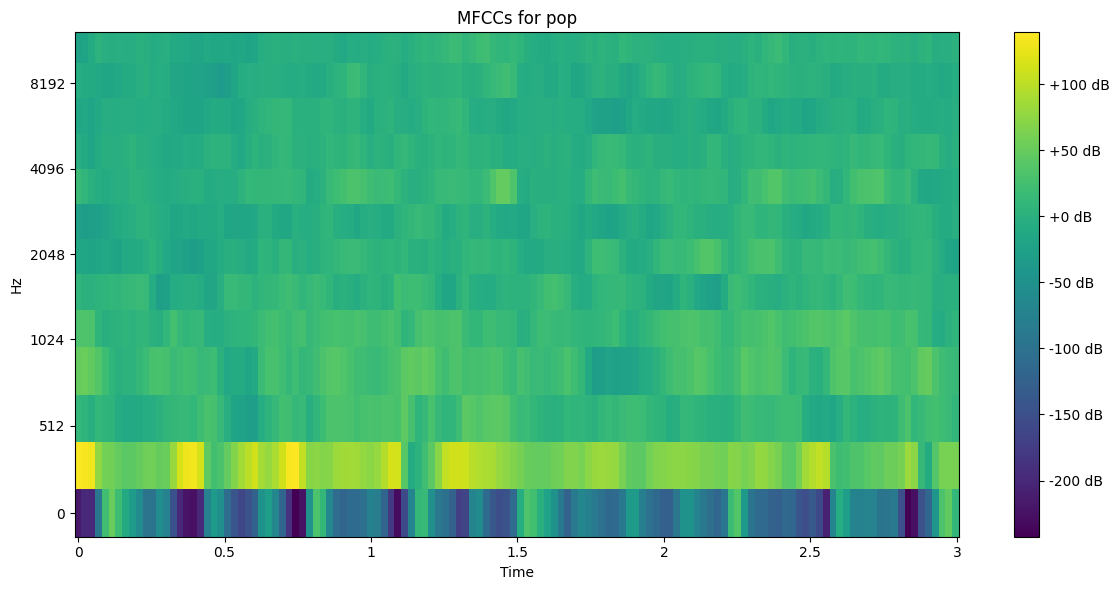

In [ ]:
# showing the first MFCCs
idx = 0
plot_mfcc(mfccs[idx].T, fs, title=f"MFCCs for {genres[idx]}")

# MODEL BUILDING

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [44]:
path = './data.json'
with open(path, 'r') as f:
    data = json.load(f)

X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (5242, 130, 13)
Validation data shape: (1748, 130, 13)
Testing data shape: (2996, 130, 13)


CNN no regularization

In [50]:
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]
input_shape = X_train_cnn.shape[1:4]

In [51]:
model_cnn = Sequential()

# convolutional and pooling layers
model_cnn.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=3, strides=(2, 2), padding='same'))

# second convolutional block
model_cnn.add(Conv2D(64, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=3, strides=(2, 2), padding='same'))

# third convolutional block
model_cnn.add(Conv2D(64, kernel_size=2, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=(2, 2), padding='same'))

# flatten output, add dense layer, and output layer to 10 classes with softmax activation
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(10, activation='softmax'))

/Users/krishnanshugupta/Cal Poly/CSC487/487/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,418 (380.54 KB)

 Trainable params: 97,418 (380.54 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist_cnn = model_cnn.fit(X_train_cnn, y_train,
                         validation_data=(X_val_cnn, y_val),
                         batch_size=64, epochs=250)

Epoch 1/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5515 - loss: 1.2416 - val_accuracy: 0.5252 - val_loss: 1.3394
Epoch 2/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5751 - loss: 1.1740 - val_accuracy: 0.5458 - val_loss: 1.2801
Epoch 3/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6213 - loss: 1.0655 - val_accuracy: 0.5452 - val_loss: 1.2602
Epoch 4/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6202 - loss: 1.0545 - val_accuracy: 0.5686 - val_loss: 1.2358
Epoch 5/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6484 - loss: 0.9948 - val_accuracy: 0.5801 - val_loss: 1.2181
Epoch 6/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6682 - loss: 0.9356 - val_accuracy: 0.5835 - val_loss: 1.1863
Epoch 7/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6636 - loss: 0.9373 - val_accuracy: 0.5967 - val_loss: 1.1751
Epoch 8/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6895 - loss: 0.8746 - val_accuracy: 0.

In [57]:
loss, accuracy = model_cnn.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7037 - loss: 1.9163
Test Loss: 2.0479
Test Accuracy: 0.6886


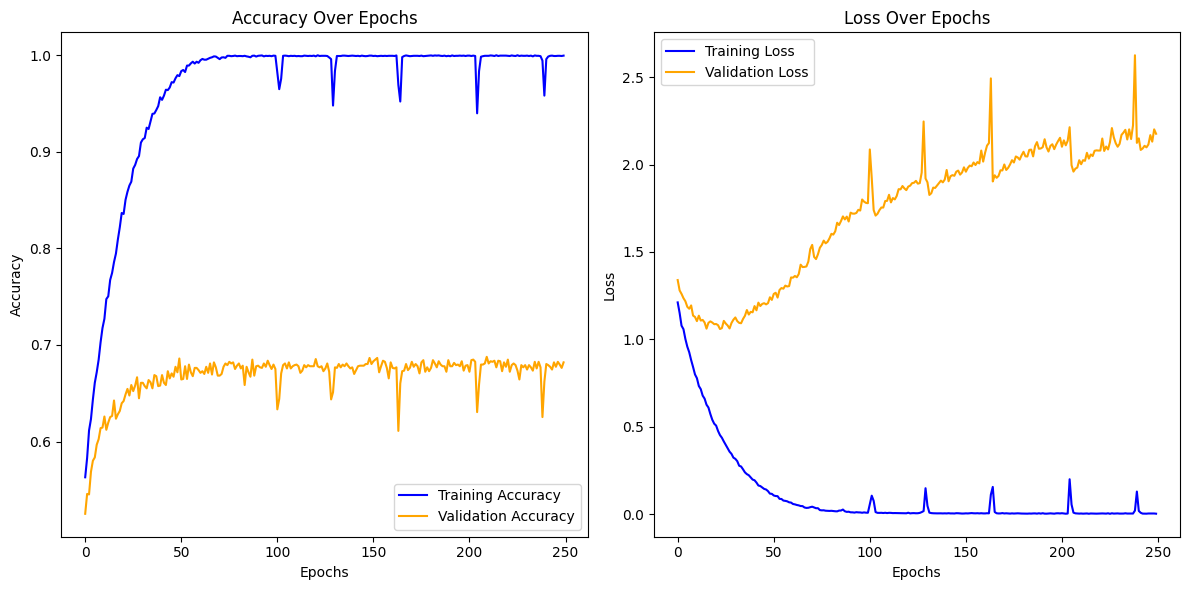

In [ ]:
def plot_training_history(hist):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Training Loss', color='blue')
    plt.plot(hist.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(hist_cnn)

CNN with regularization

In [59]:
model_cnn2 = Sequential()

# convolutional, batch normalization, and pooling layers (with 20% dropout)
model_cnn2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(pool_size=3, strides=(2, 2), padding='same'))
model_cnn2.add(Dropout(0.2))

# second convolutional block
model_cnn2.add(Conv2D(64, kernel_size=3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(pool_size=3, strides=(2, 2), padding='same'))
model_cnn2.add(Dropout(0.2))

# third convolutional block
model_cnn2.add(Conv2D(64, kernel_size=2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(pool_size=2, strides=(2, 2), padding='same'))
model_cnn2.add(Dropout(0.2))

# flatten output, add dense layer, and output layer to 10 classes with softmax activation
model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))
model_cnn2.add(Dense(10, activation='softmax'))

model_cnn2.summary()

/Users/krishnanshugupta/Cal Poly/CSC487/487/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 11, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 159,882 (624.54 KB)

 Non-trainable params: 320 (1.25 KB)

In [69]:
model_cnn2.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
hist_cnn2 = model_cnn2.fit(X_train_cnn, y_train,
                           epochs=250, batch_size=64,
                           validation_data=(X_val_cnn, y_val))

Epoch 1/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6004 - loss: 1.1145 - val_accuracy: 0.5481 - val_loss: 1.6957
Epoch 2/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5927 - loss: 1.1351 - val_accuracy: 0.5664 - val_loss: 1.5606
Epoch 3/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6052 - loss: 1.1172 - val_accuracy: 0.5658 - val_loss: 1.6455
Epoch 4/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6270 - loss: 1.0457 - val_accuracy: 0.5572 - val_loss: 1.6630
Epoch 5/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6140 - loss: 1.0781 - val_accuracy: 0.5606 - val_loss: 1.6579
Epoch 6/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6248 - loss: 1.0823 - val_accuracy: 0.5738 - val_loss: 1.7007
Epoch 7/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6291 - loss: 1.0532 - val_accuracy: 0.5807 - val_loss: 1.6526
Epoch 8/250
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6406 - loss: 1.0207 - val_accuracy: 0.

In [71]:
loss2, accuracy2 = model_cnn2.evaluate(X_test_cnn, y_test)

print(f"Test Loss (Regularized CNN): {loss2:.4f}")
print(f"Test Accuracy (Regularized CNN): {accuracy2:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7878 - loss: 0.8726
Test Loss (Regularized CNN): 0.8891
Test Accuracy (Regularized CNN): 0.7864


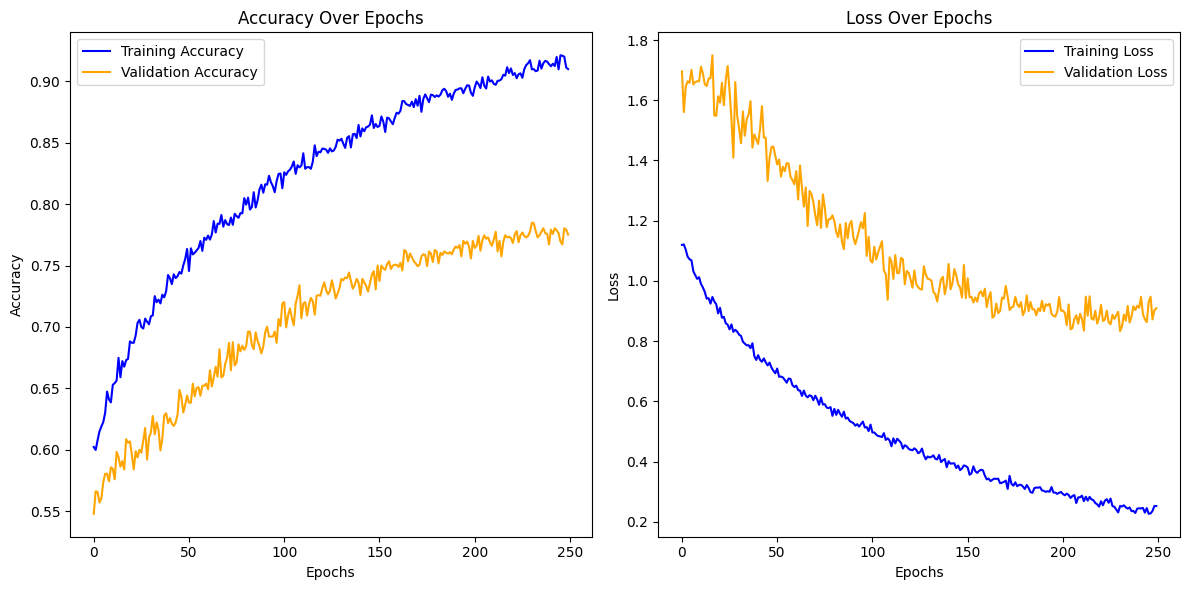

In [72]:
plot_training_history(hist_cnn2)

CNN with regularization and augmentation

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(vertical_flip=True)

In [81]:
model_cnn3 = Sequential()

# convolutional, batch normalization, and pooling layers (with 20% dropout)
model_cnn3.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape=input_shape))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(pool_size=3, strides=(2, 2), padding='same'))
model_cnn3.add(Dropout(0.2))

# second convolutional block
model_cnn3.add(Conv2D(64, kernel_size = 3, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(pool_size=3, strides=(2, 2), padding='same'))
model_cnn3.add(Dropout(0.2))

# third convolutional block
model_cnn3.add(Conv2D(64, kernel_size = 2, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(pool_size=2, strides=(2, 2), padding='same'))
model_cnn3.add(Dropout(0.2))

# flatten output, add dense layer, and output layer to 10 classes with softmax activation
model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu'))
model_cnn3.add(Dropout(0.5))
model_cnn3.add(Dense(10, activation='softmax'))

model_cnn3.summary()

/Users/krishnanshugupta/Cal Poly/CSC487/487/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 11, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 62, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 30, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 159,882 (624.54 KB)

 Non-trainable params: 320 (1.25 KB)

In [82]:
model_cnn3.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
hist_cnn3 = model_cnn3.fit(datagen.flow(X_train_cnn, y_train, batch_size=64),
                           epochs=400, validation_data=(X_val_cnn, y_val),
                           callbacks=[early_stopping])

Epoch 1/400
 3/82 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.1016 - loss: 4.0663

/Users/krishnanshugupta/Cal Poly/CSC487/487/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.1326 - loss: 3.6747 - val_accuracy: 0.2466 - val_loss: 2.1775
Epoch 2/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2508 - loss: 2.6287 - val_accuracy: 0.3307 - val_loss: 1.9315
Epoch 3/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2950 - loss: 2.2735 - val_accuracy: 0.3535 - val_loss: 1.9318
Epoch 4/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3237 - loss: 2.0525 - val_accuracy: 0.3919 - val_loss: 1.8735
Epoch 5/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3350 - loss: 1.9395 - val_accuracy: 0.4016 - val_loss: 1.8515
Epoch 6/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3503 - loss: 1.8637 - val_accuracy: 0.3987 - val_loss: 1.9229
Epoch 7/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3827 - loss: 1.7290 - val_accuracy: 0.4170 - val_loss: 1.8992
Epoch 8/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4002 - loss: 1.6798 - val_accuracy: 0.4239 - val_l

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7704 - loss: 0.7712
Test Loss (Augmented CNN): 0.8000
Test Accuracy (Augmented CNN): 0.7690


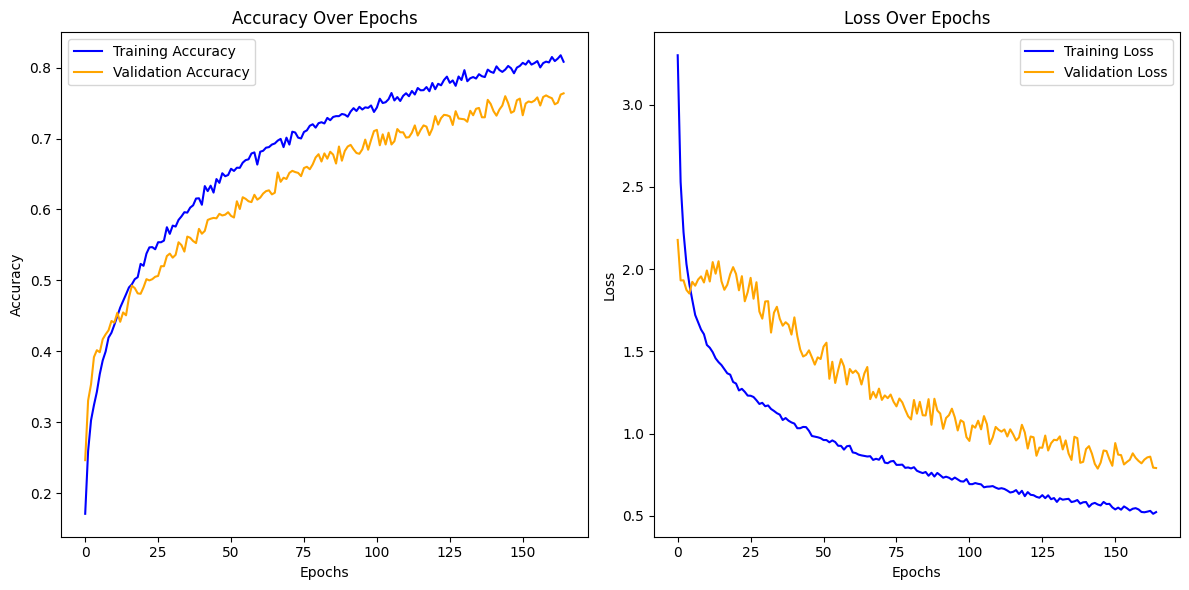

In [83]:
loss_aug, accuracy_aug = model_cnn3.evaluate(X_test_cnn, y_test)

print(f"Test Loss (Augmented CNN): {loss_aug:.4f}")
print(f"Test Accuracy (Augmented CNN): {accuracy_aug:.4f}")

plot_training_history(hist_cnn3)

Save Models

In [102]:
model_cnn.save("model_cnn.h5")
model_cnn2.save("model_cnn2.h5")
model_cnn3.save("model_cnn3.h5")

In [87]:
from tensorflow.keras.models import load_model

model_cnn3 = load_model("model_cnn3.h5")
model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
initial_epoch = 165
hist_cnn3_cont = model_cnn3.fit(datagen.flow(X_train_cnn, y_train, batch_size=64),
                                epochs = 400,
                                initial_epoch = initial_epoch,
                                validation_data = (X_val_cnn, y_val))

Epoch 166/400
 3/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8064 - loss: 0.5550

/Users/krishnanshugupta/Cal Poly/CSC487/487/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8025 - loss: 0.5605 - val_accuracy: 0.7374 - val_loss: 0.8763
Epoch 167/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7903 - loss: 0.5724 - val_accuracy: 0.7397 - val_loss: 0.8807
Epoch 168/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7882 - loss: 0.5731 - val_accuracy: 0.7534 - val_loss: 0.8074
Epoch 169/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7941 - loss: 0.5587 - val_accuracy: 0.7500 - val_loss: 0.8507
Epoch 170/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7959 - loss: 0.5670 - val_accuracy: 0.7380 - val_loss: 0.8659
Epoch 171/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8011 - loss: 0.5473 - val_accuracy: 0.7523 - val_loss: 0.8429
Epoch 172/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7997 - loss: 0.5819 - val_accuracy: 0.7483 - val_loss: 0.8704
Epoch 173/400
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8057 - loss: 0.5476 - val_accuracy: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8237 - loss: 0.6428
Test Loss (Augmented CNN): 0.6692
Test Accuracy (Augmented CNN): 0.8211


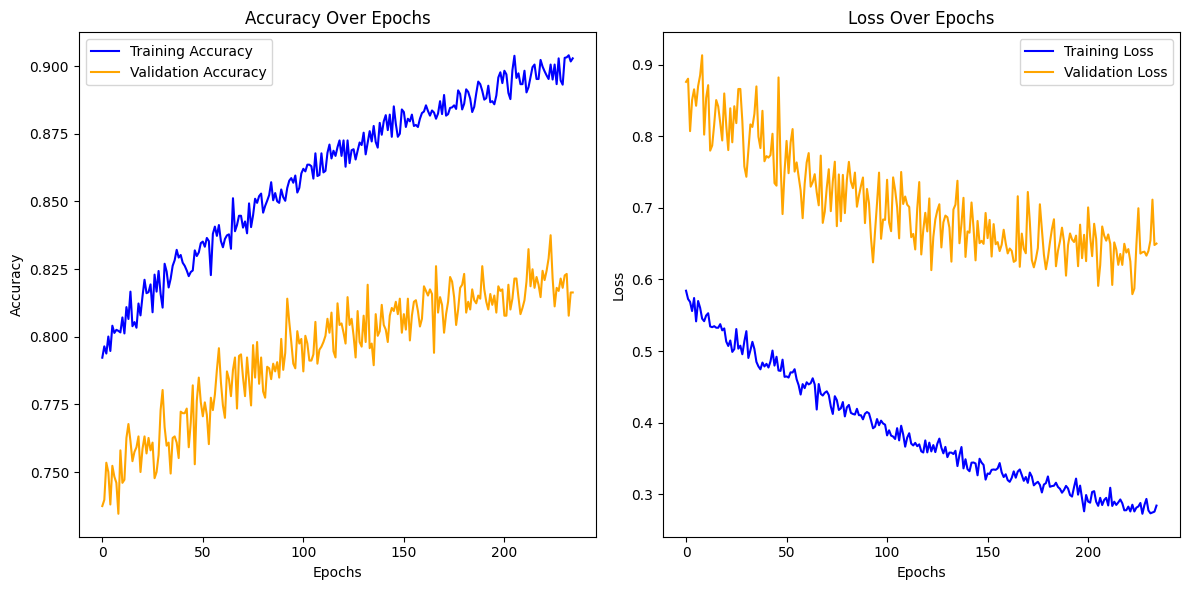

In [88]:
loss_aug, accuracy_aug = model_cnn3.evaluate(X_test_cnn, y_test)

print(f"Test Loss (Augmented CNN): {loss_aug:.4f}")
print(f"Test Accuracy (Augmented CNN): {accuracy_aug:.4f}")

plot_training_history(hist_cnn3_cont)

In [89]:
model_cnn3.save("model_cnn3.h5")

In [ ]:
def make_prediction(model, X):
    """Makes predictions given a keras model and a set of data.

    Parameters:
        model (keras model): The model to use to make predictions
        X (np.sdarray): Testing data to be fed into the model to make predictions with.

    Returns:
        preds_num (list): List of genre predictions (number format, 0-9)
        preds_name (list): List of genre predictions (str format)
    """
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1) # predicted index
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])

    return preds_num, preds_name

In [ ]:
X_test_first_5 = X_test_cnn[:5]
preds_num2, preds_name2 = make_prediction(model_cnn3, X_test_first_5)
print("Predictions for the first 5 songs:")
for idx, (num, name) in enumerate(zip(preds_num2, preds_name2), start=1):
    print(f"Song {idx}: Genre Index = {num}, Genre Name = {name}")

# Get the true labels for the first 5 songs
true_labels = y_test[:5]

# Compare predictions with true labels
for idx, (true_label, pred_label, pred_name) in enumerate(zip(true_labels, preds_num2, preds_name2), start=1):
    print(f"Song {idx}: True Genre Index = {true_label}, Predicted Genre Index = {pred_label}, Predicted Genre Name = {pred_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predictions for the first 5 songs:
Song 1: Genre Index = 7, Genre Name = pop
Song 2: Genre Index = 5, Genre Name = jazz
Song 3: Genre Index = 9, Genre Name = rock
Song 4: Genre Index = 4, Genre Name = hiphop
Song 5: Genre Index = 3, Genre Name = disco
Song 1: True Genre Index = 7, Predicted Genre Index = 7, Predicted Genre Name = pop
Song 2: True Genre Index = 5, Predicted Genre Index = 5, Predicted Genre Name = jazz
Song 3: True Genre Index = 9, Predicted Genre Index = 9, Predicted Genre Name = rock
Song 4: True Genre Index = 4, Predicted Genre Index = 4, Predicted Genre Name = hiphop
Song 5: True Genre Index = 3, Predicted Genre Index = 3, Predicted Genre Name = disco


In [91]:
preds_num, preds_name = make_prediction(model_cnn3, X_test_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━

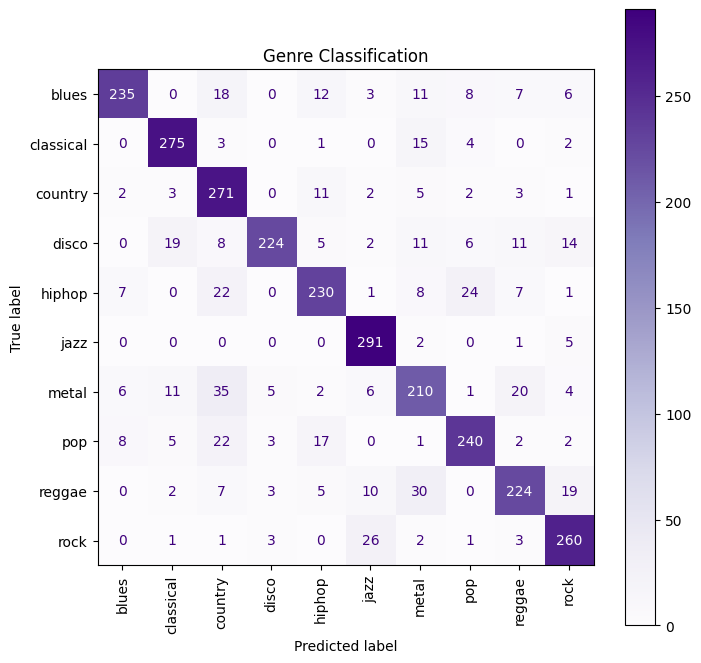

In [93]:
cm = confusion_matrix(y_test, preds_num)

# Define genre labels
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Create a confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap='Purples', xticks_rotation='vertical')

# Add a title to the plot
plt.title('Genre Classification')
plt.show()